# Imports

In [2]:
import time
import serial
import sqlite3
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import argrelextrema

# Read in JSON

In [97]:
with open('rpeaks.txt') as f:
  lineList = f.read()

new_rpeaks = json.loads(lineList)


with open('filtered_sig.txt') as f:
  lineList = f.read()

temp_list = json.loads(lineList)
new_filtered_sig = np.array(temp_list)


# BiometricSignal Class

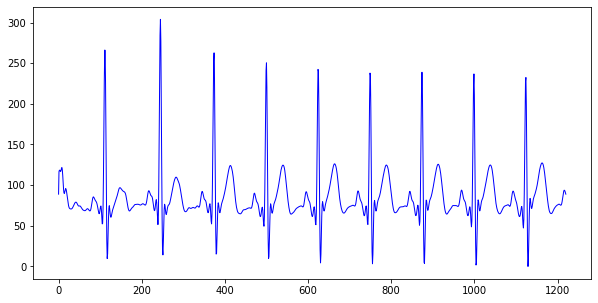

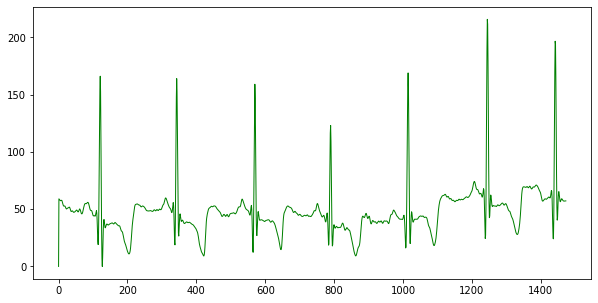

<Figure size 800x400 with 0 Axes>

In [99]:
class BiometricSignal: 
    """
    A class used to represent an ECG signal

    ...

    Attributes
    ----------
    captured_signal_csv : str
        a string representing a path to a csv file

    Methods
    -------
    capture_signal()
        Captures an ECG signal with an Arduino and AD8232
    output_signal_to_csv()
        Outputs the signal captured to a csv name in 'captured_signal_csv'
    filter_captured_signal()
        Filters the ECG to reduce noise
    amend_signal(filtered_signal)
        Removes start and end of signal which are usually very noisy
    standardise_signal()
        Resets the Y axis to start at zero
    find_r_peaks(amended_signal)
        Finds the R-peaks in the signal
    """
    
    captured_signal_csv = "./assets/subject_raw_ecg.csv"

    def __init__(self):
        """
        Parameters
        ----------
        captured_ecg : list
            List containing the ECG captured by the Arduino and AD8232
        filtered_signal : numpy.ndarray
            The signal with most of the noise removed
        amended_signal : numpy.ndarray
            The signal with the start and the end removed
        r_peaks : tuple
            Contains the positions of the R-peaks in the signal
        """
        
        self.captured_ecg = []
        self.filtered_signal = np.ndarray([])
        self.amended_signal = np.ndarray([])
        self.standardised_signal = np.ndarray([])
        self.r_peaks = ()
        
        
#     def capture_signal(self, serial_data = serial.Serial("/dev/ttyACM2", 9600), capture_time = 5, start_delay = 2):
#         r"""Captures ECG signal from Arduino and AD8232.

#         This function captures an ECG signal with an Arduino and AD8232
#         on the port specified in `serial_data`. Before it begins capturing,
#         there is a small delay (e.g. 2 seconds) to allow the user to get
#         comfortable. After this delay it will capture the ECG signal and
#         assign it to the list `self.captured_ecg`.
        
#         Parameters
#         ----------
#         serial_data : serial.serialposix.Serial, optinal
#             Identifies the port to record the ECG signal, default is
#             serial.Serial("/dev/ttyACM2", 9600)
#         capture_time : int, optional
#             Time in seconds to capture ECG signal for, default is 5 
#         start_delay : int, optional
#             Time in seconds to delay before recording starts, default is 2

#         """
        
#         t_end = time.time() + capture_time
#         time.sleep(start_delay)

#         while time.time() < t_end:
#             while serial_data.inWaiting() == 0:
#                 pass
#             temp_string = serial_data.readline()
#             serial_string = (
#                 str(temp_string)
#                 .replace("b", "")
#                 .replace("'", "")
#                 .replace("\\r", "")
#                 .replace("\\n", "")
#             )
#             if len(serial_string) == 3:
#                 self.captured_ecg.append(int(serial_string))
# #         return self.captured_ecg


    def output_signal_to_csv(self):
        
        r"""Coverts `self.captured_ecg` to a csv

        This function converts the list `self.captured_ecg` to a csv and
        saves it to the location set in `captured_signal_csv`.
        
        """
        
        with open(BiometricSignal.captured_signal_csv, "w") as ecg_file:
            ecg_file.write("voltage,\n")
            for item in self.captured_ecg:
                ecg_file.write("%s,\n" % item)
            ecg_file.write("0,")


    def filter_captured_signal(self):
        
        r"""Reduces noise in the signal.

        Reduces noise which in picked up when recording an ECG signal.
        It uses a Butterworth filter to remove jagged parts of the signal
        and smoothen it give a more truer represtation of the ECG signal.
        
        Returns
        -------
        self.filtered_signal : numpy.ndarray
            A filtered version of the captured ECG signal 

        """
            
        numerator, denominator = signal.butter(4, 0.25, analog=False)
        data = pd.read_csv(BiometricSignal.captured_signal_csv)
        sig = data["voltage"]
        self.filtered_signal = signal.filtfilt(numerator, denominator, sig)
        return self.filtered_signal
    
    def amend_signal(self, start = 100, end = -100):
        r"""Removes the begining and end of a filtered signal

        Sometimes there can be a lot of noise at the start and of a ECG
        signal which the `filter_captured_signal` function is unable to remove.
        The noise is caused by connecting to and from the capture device. This
        function takes care of that of that noise by removing the start and end of
        the captured ECG signal.
        
        Parameters
        ----------
        start : int, optinal
            The position to start the clip the ECG signal from, default is 100
        end : int, optional
            The position to end the clip of the ECG signal, default is 100
            
        Returns
        -------
        self.amended_signal : numpy.ndarray
            An ammended version of `filtered_signal` 
            
        """
             
        self.amended_signal = self.filtered_signal[start:end]
        return self.amended_signal
    
    def standardise_signal(self):
        r"""Resets the Y axis to start at zero

        The Y axis on an ECG signal never starts at zero because there is
        always some electrical activity from the heart. This function resets
        this and starts the scale at zero for easier more accurate 
        processing.
            
        Returns
        -------
        self.standardised_signal : numpy.ndarray
            An standardised ECG signal
            
        """
        
        for i in range(0, len(self.amended_signal)):
            self.standardised_signal = np.append (self.standardised_signal, self.amended_signal[i] - min(self.amended_signal))

        return self.standardised_signal
    
    def find_r_peaks(self, threshold = 400):
        r"""Finds the R-peaks in an amended signal

        This function finds the R-peaks in an amended signal. R-peaks are 
        the highest part of a signal so it uses a threshold to illimitate lower
        unnesscary features which may be picked up as a false positive. 
        
        Parameters
        ----------
        threshold : int, optinal
            The position to start looking for R-peaks from, default is 400
            
        Returns
        -------
        self.r_peaks : tuple
            A tuple containing the positions of the R-peaks 
            
        """
        
        no_of_rows = self.amended_signal.shape[0]
        line_numbers = []
        theVoltage = []


        for i in range(0, no_of_rows):
            if self.amended_signal[i] > threshold:
                theVoltage.append(self.amended_signal[i])
            else:
                theVoltage.append(0)
            line_numbers.append(i)    


        ecg_plot = np.concatenate((theVoltage, line_numbers))

        self.r_peaks = argrelextrema(ecg_plot, np.greater, order=5)
        
        return self.r_peaks


# ----------------------------------------------------------------------------------------------
#                                       CODE FOR TESTING
# ----------------------------------------------------------------------------------------------
biosig = BiometricSignal()
biosig.filter_captured_signal()
biosig.amend_signal()
biosig.find_r_peaks()
biosig.standardise_signal()

biosig2 = BiometricSignal()
biosig2.filtered_signal = new_filtered_sig
biosig2.amend_signal()
biosig2.find_r_peaks()
biosig2.standardise_signal()

fig1, ax1 = plt.subplots(figsize=(10,5))
fig2, ax2 = plt.subplots(figsize=(10,5))

plt.figure(num=None, figsize=(10, 5), dpi=80)
ax1.plot(biosig.standardised_signal, linewidth=1, color='b')
ax2.plot(biosig2.standardised_signal, linewidth=1, color='g')
plt.tight_layout()
plt.show()

# Segment Class

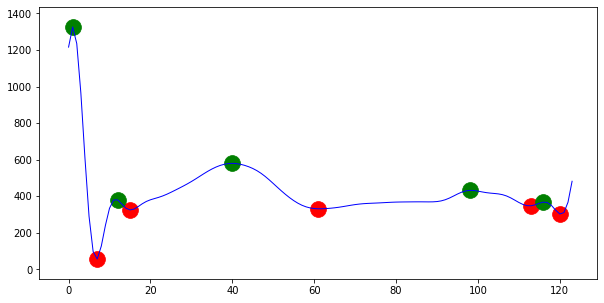

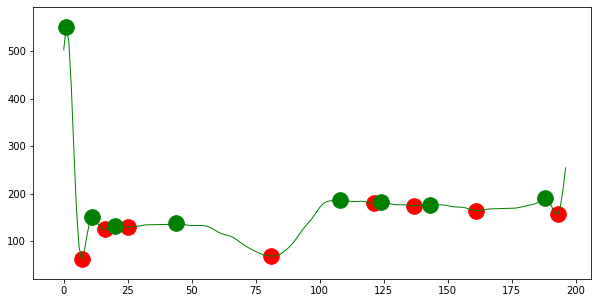

<Figure size 800x400 with 0 Axes>

In [125]:
class Segment:
    """
    A segment is a section of an ECG signal between two neighbouring R-peaks

    ...
    
    Attributes
    ----------
    no_of_segments : int
        a int representing the number of segemnts to overlay
        
    Methods
    -------
    combining_segments()
        Combines multiple segments, overlayed on each other
    find_features_lower()
        Finds the lower unique features of a segment
    find_features_higher()
        Finds the higher unique features of a segment
    """
    
    
    
    
    def __init__(self, bio_signal, no_of_segments = 5):
        """
        Parameters
        ----------
        bio_signal : BiometricSignal
            An ECG signal object
        combined_seg : numpy.ndarray
            Contains multiple segments overlayed on each other 
        features_lower() : tuple
            The lower side unique features of a segment
        features_higher() : tuple
            The higher side unique features of a segment
        """
        
        self.no_of_segments = no_of_segments
        self.bio_signal = bio_signal
        self.combined_seg = self.combining_segments()
        self.features_lower = self.find_features_lower()
        self.features_higher = self.find_features_higher()


    def combining_segments(self):
        r"""Combines multiple segments, overlayed on one another

        This function combines multiple neighbouring R-peaks and overlays them
        to form a single segment. This an average over multiple segments.
                   
        Returns
        -------
        combined_seg : numpy.ndarray
            A numpy array containing multiple segments overlayed on one another
        """
        
        combined_seg_does_not_exist = True
        smallest_seg = None
        
        for i in range (0, self.no_of_segments):
            segment_start = self.bio_signal.r_peaks[0][i]
            segment_end = self.bio_signal.r_peaks[0][i+1]

            extracted_segment = self.bio_signal.standardised_signal[segment_start:segment_end]
            if smallest_seg == None:
                smallest_seg = len(extracted_segment)
            elif (len(extracted_segment) < smallest_seg):
                smallest_seg = len(extracted_segment)

            if combined_seg_does_not_exist:
                # adds additional zeros to the end of the first segment
                # this is to prevent a crash as segments may have differnet lengths
                combined_seg = np.zeros(len(extracted_segment) + 100)
                combined_seg_does_not_exist = False
            for j in range(0,len(extracted_segment)):
                combined_seg[j] =  combined_seg[j] + extracted_segment[j]
            
        combined_seg = np.trim_zeros(combined_seg)
        combined_seg = combined_seg[0:smallest_seg]
        return combined_seg
                
   
    def find_features_lower(self):
        r"""Finds the lower unique features of a segment

        This function uses argrelextrema, part of SciPy. Argrelextrema
        calculates the relative extrema of data, this means it examines
        data at either side of a point on the segment to identify variation.
        When if finds broad variations between points, it considers it unique, 
        labels that point as a feature and stores it in a tuple.
            
        Returns
        -------
        features_lower : tuple
            A tuple containing the positions of lower unique features. 
        """
        
        features_lower = argrelextrema(self.combined_seg, np.less, order=5)
        self.features_lower = (features_lower[0],self.combined_seg[features_lower[0]])       
        return self.features_lower


    def find_features_higher(self):
        r"""Finds the higher unique features of a segment

        This function uses argrelextrema, part of SciPy. Argrelextrema
        calculates the relative extrema of data, this means it examines
        data at either side of a point on the segment to identify variation.
        When if finds broad variations between points, it considers it unique, 
        labels that point as a feature and stores it in a tuple.
            
        Returns
        -------
        features_higher : tuple
            A tuple containing the positions of higher unique features. 
        """
        
        features_higher = argrelextrema(self.combined_seg, np.greater, order=5)
        self.features_higher = (features_higher[0],self.combined_seg[features_higher[0]]) 
        return self.features_higher

        
# ----------------------------------------------------------------------------------------------
#                                       CODE FOR TESTING
# ----------------------------------------------------------------------------------------------
seg = Segment(biosig)
seg2 = Segment(biosig2, 3)

fig1, ax1 = plt.subplots(figsize=(10,5))
fig2, ax2 = plt.subplots(figsize=(10,5))

plt.figure(num=None, figsize=(10, 5), dpi=80)
ax1.plot(seg.combined_seg, linewidth=1, color='b')
ax1.scatter(seg.features_lower[0],seg.combined_seg[seg.features_lower[0]],linewidth=0.75, s=250, c='r')
ax1.scatter(seg.features_higher[0],seg.combined_seg[seg.features_higher[0]],linewidth=0.75, s=250, c='g')

ax2.plot(seg2.combined_seg, linewidth=1, color='g')
ax2.scatter(seg2.features_lower[0],seg2.combined_seg[seg2.features_lower[0]],linewidth=0.75, s=250, c='r')
ax2.scatter(seg2.features_higher[0],seg2.combined_seg[seg2.features_higher[0]],linewidth=0.75, s=250, c='g')

plt.tight_layout()
plt.show()

# Templates Class

('Success rate: ', 100.0)

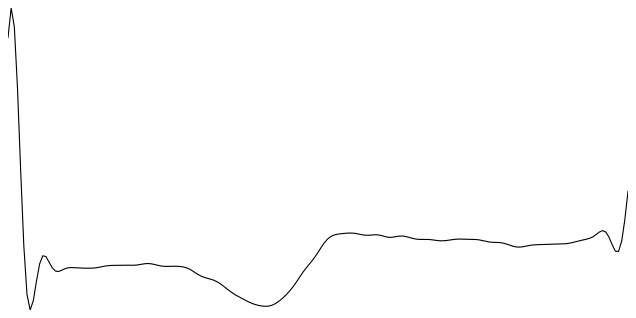

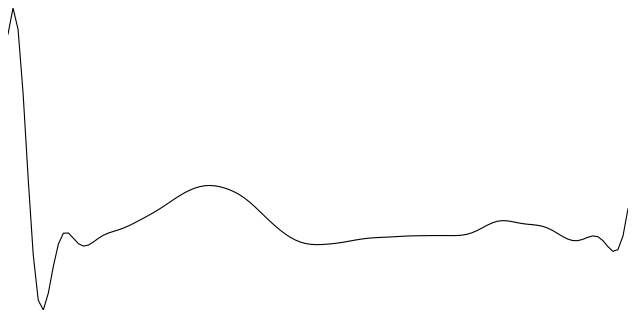

In [138]:
class Templates:
    """
    A class for templates for ECG signals

    ...

    Methods
    -------
    create_table()
        Creates the templates table in the database if it doesn't already exist
    add_entry_to_database(features_lower, features_higher, combined_seg, x_length, y_length)
        Adds a record to the database
    convert_features_to_percentages(features, length)
        Converts the feature locations to percentages
    query_db(theName)
        Searchs for a name in the database
    does_user_exist(theName)
        Checks to see if user already exists in the database
    get_template()
        Retrieves a template from the database
    template_matching()
        Compares the template in the database with a captured one
    get_start_end_locations(self, feature_x, feature_y, image_width, image_height)
        Uses a feature to determine a area to check for a match
    create_image(biosignal, name):
        Converts a combined segment to a image for template matching
    
    """

    def __init__(self, name):
        """
        Parameters
        ----------
        name : str
            The name of the user
        conn : sqlite3.Connection
            Connection to the SQLite3 database
        c : sqlite3.Cursor
            Cursor for the SQLite3 database
        combined_seg : numpy.ndarray
            Standareised segment, standisating in nesscessary for processing
        featuresX : list
            A list of all the features on the X axis
        featuresY : list
            A list of all the features on the Y axis
        """

        self.name = name
        self.conn = sqlite3.connect('templatesDB.db')
        self.c = self.conn.cursor()
        self.create_table()
        self.combined_seg = []
        self.featuresX = []
        self.featuresY = []
    
    def create_table(self):
        r"""Creates the templates table in the database if it doesn't already exist

        Checks to see if table for the templates exists and creates it if it doesn't.
        The table contains the name, combined_seg, features along the X axis and 
        features along the Y axis
        """
        
        self.c.execute("""CREATE TABLE IF NOT EXISTS templates 
                                            ( name text,
                                                combined_seg text,
                                                featuresX text,
                                                featuresY text)""")
        self.conn.commit()
    
    
    def add_entry_to_database(self, features_lower, features_higher, combined_seg,
                          x_length, y_length):
        r"""Adds a record to the database

        Adds a new user to the database. It starts by converting the feature locations
        to percentages for both the lower and higher features. This standardises the 
        locations making matching more accurate. It then adds them to the database,
        combining X axises of both lower and higher features, and doing the
        same for the Y axises. It also sotres the user and the user's standarised
        mean segment.
        
        Parameters
        ----------
        features_lower : tuple
            A tuple containing the positions of lower unique features.
        features_higher : tuple
            A tuple containing the positions of higher unique features.
        combined_seg : numpy.ndarray
            Standareised mean segment, standisatin in nesscessary for processing
        x_length : int
            The length of the X axis
        y_length : int
            The length of the Y axis 
        """
        if self.does_user_exist(self.name) != True:
            thefeaturesLowerX = self.convert_features_to_percentages(features_lower[0].tolist(), x_length)
            thefeaturesLowerY = self.convert_features_to_percentages(features_lower[1].tolist(), y_length)
            thefeaturesHigherX = self.convert_features_to_percentages(features_higher[0].tolist(), x_length)
            thefeaturesHigherY = self.convert_features_to_percentages(features_higher[1].tolist(), y_length)
            
            
            
            self.c.execute("INSERT INTO templates VALUES (:name, :combined_seg, :featuresX, :featuresY)",
                            {'name': self.name,
                             'combined_seg': json.dumps(combined_seg.tolist()),
                             'featuresX': json.dumps(thefeaturesLowerX + thefeaturesHigherX),
                             'featuresY': json.dumps(thefeaturesLowerY + thefeaturesHigherY)})


            self.conn.commit()
        
        
    def convert_features_to_percentages(self, features, length):
        r"""Converts a feature's location to a percentage

        Converts the location of a feature to a percentage for
        standardisaion. When converted to an image for template matching,
        if there is any slight difference in image size, OpenCV will
        not work. Using the x,y position of a feature as a percentage, rather
        than its true x,y corordinate in relation to the image helps solve this.
        
        Parameters
        ----------
        features : numpy.ndarray
            An array containing the features
        length : int
            The length of the features array
            
        Returns
        -------
        the_row : list
            Returns a list of ints
            
        """
        
        the_row = []

        for i in features:
            pos_percentage = (i * 100) // length
            the_row.append(int(pos_percentage))
            
        [int(i) for i in the_row]
            
        return the_row
    

    def query_db(self, theName):
        r"""Queries the database with the name provided in arguments

        Queries the database with the name provided in arguments and
        returns the result if there is one.
        
        Parameters
        ----------
        theName : str
            The name used in the query
            
        Returns
        -------
        query_response : tuple
            The result, if any, of the query
            
        """
        
        self.c.execute("SELECT * FROM templates WHERE name IS (:name)", {'name': theName})
        query_response=(self.c.fetchone())        
        return query_response
    
    def does_user_exist(self, theName):
        r"""Queries the database with the name provided in arguments

        Queries the database with the name provided in arguments and
        returns a bool.
        
        Parameters
        ----------
        theName : str
            The name used in the query
            
        Returns
        -------
        bool
            True or false, depending on if name is found in database
        """
        
        if self.query_db(theName) == None:
            return False
        else:
            return True
        
        
    def get_template(self, theName):
        r"""Retrieves template from the database

        Queries the database with the name provided in arguments and
        returns the result if there is one.
        
        Parameters
        ----------
        theName : str
            The name used in the query
            
        Returns
        -------
        combined_seg : list
            The users segment
        featuresX : list
            The X cordinates of the the features
        featuresY : list
            The X cordinates of the the features            
        """
        
        if self.does_user_exist(theName):
            query_response = self.query_db(theName)
            self.combined_seg = json.loads(query_response[1])
            self.featuresX = json.loads(query_response[2])
            self.featuresY = json.loads(query_response[3])
            return self.combined_seg, self.featuresX, self.featuresY
    
    
    def get_start_end_locations(self, feature_x, feature_y):
        r"""Identifies area to check on the template

        The features are a single point on the segment, this function
        takes the area around that point to include in the template match
        to increase its accuracity. It also takes into account where
        the point is, and if its close to an edge to make sure it doesn't
        go out of bounds.
        
        Parameters
        ----------
        feature_x : list
            The cordinates on X axis
        feature_y : list
            The cordinates on Y axis
        image_width : int
            The segments width
        image_height : int
            The segments length
            
        Returns
        -------
        x_start : int
            The starting X cordinate needed for OpenCV
        x_end : int
            The ending X cordinate needed for OpenCV
        y_start : int
            The starting Y cordinate needed for OpenCV
        y_end : type
            The ending Y cordinate needed for OpenCV  
        """
        
        margin = 50
        y_start = feature_y - margin
        y_end = feature_y + margin
        x_start = feature_x - margin
        x_end = feature_x + margin 
        
        return y_start, y_end, x_start, x_end
            

    def create_image(self, biosignal, name):
        r"""Creates an image for OpenCV to use in template matching

        OpenCV requires images for template matching. This converts a
        combined segemnt to image, and saves it to the assets folder.
        
        Parameters
        ----------
        biosignal : Segment.combined_seg
            The segment to to made into an image
        name : str
            The name of segment, either capture or template
            
        """
        
        plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor="w", edgecolor="k")
        plt.margins(0,0)
        plt.plot(biosignal, color="#000000", linewidth=1)
        plt.axis('off')
        plt.savefig("./assets/"+name+".png", dpi=150, quality=100, bbox_inches='tight', pad_inches=0)

        
    def template_matching(self, captured_seg):
        r"""Compares the captured template with the one in the database

        Compares the captured template with the one in the database. Loops
        through each each feature of the captured ECG signal and compares
        it to that in the database.
            
        Returns
        -------
        success_rate : float
            The success rate of the matches
        """
    
        self.create_image(self.combined_seg, 'template')
        self.create_image(captured_seg, 'captured')
        
        template_ecg = cv2.imread("./assets/template.png", 0)
        captured_ecg = cv2.imread("./assets/captured.png", 0)

        
        total_matches = 0
        successful_matches = 0
        image_height, image_width = template_ecg.shape
        
        for x,y in zip(self.featuresX, self.featuresY):
            
            if x > 10 and x < 90 and y > 10 and y < 90 :
                
                
                xpos = (image_width // 100) * x
                ypos = (image_height // 100) * (100 - y)
                y_start, y_end, x_start, x_end = self.get_start_end_locations(xpos, ypos)

                feature_to_match = template_ecg[y_start:y_end,x_start:x_end]
                res = cv2.matchTemplate(captured_ecg,feature_to_match,cv2.TM_CCOEFF_NORMED)

                threshold = 0.9      
                loc = np.where( res >= threshold)
                if np.amax(res) > threshold:
                    total_matches += 1
                    successful_matches += 1
                else:
                    total_matches += 1

        success_rate = (successful_matches * 100) / total_matches
        return ("Success rate: ", success_rate)
    
        
# ----------------------------------------------------------------------------------------------
#                                       CODE FOR TESTING
# ----------------------------------------------------------------------------------------------
templ = Templates('Sam')
# templ.add_entry_to_database(seg.features_lower, seg.features_higher,
#                                      seg.combined_seg, len(seg.combined_seg), 
#                                      max(seg.combined_seg))

templ2 = Templates('Ted')
# templ2.add_entry_to_database(seg2.features_lower, seg2.features_higher,
#                                      seg2.combined_seg, len(seg2.combined_seg), 
#                                      max(seg2.combined_seg))


# ------ Compare Sam with Sam ------
# a_user_template = templ.get_template('Sam')
# templ.template_matching(seg.combined_seg)

# ------ Compare Sam with Ted ------
# a_user_template = templ.get_template('Sam')
# templ.template_matching(seg2.combined_seg)

# ------ Compare Ted with Ted ------
# a_user_template = templ2.get_template('Ted')
# templ2.template_matching(seg2.combined_seg)